<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Select Task

In [2]:
task = 10
assert task < 15

# Prepare data

In [3]:
import numpy as np
import pandas as pd

# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task + 1}/train{task + 1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [5]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()

In [6]:
predictor1 = predictor_data[['SURFACE SOLAR RADIATION 1', 'SURFACE THERMAL RADIATION 1', 'TOP NET SOLAR RADIATION 1']]

train_data1 = train_data[['ZONEID 1']]

In [7]:
x_input_df = predictor1[:-gefcom14_metadata['prediction_length']]
x_input = np.array(x_input_df)
y_output = np.array(train_data1[:-gefcom14_metadata['prediction_length']])

# NNQF

In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [9]:
yq_output = nnqf_filter(x_input=x_input, y_output=y_output, 
                        q_quantile=[p / 100 for p in range(1, 100)], 
                        num_neighbors=100).T
yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
    .rename(columns={p: str((p+1)/100) for p in range(99)})
yq_output_df

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.258974,0.304413,0.316202,0.343738,0.355103,0.396555,0.486384,0.495779,0.499701,0.513160,...,0.838763,0.841486,0.841756,0.843692,0.845924,0.847141,0.862433,0.867962,0.899538,0.902071
2012-04-01 02:00:00,0.100038,0.162827,0.185244,0.217036,0.291532,0.444399,0.488368,0.493851,0.496494,0.498058,...,0.825712,0.826502,0.828390,0.832328,0.836890,0.837381,0.837856,0.844916,0.846867,0.872732
2012-04-01 03:00:00,0.177375,0.201342,0.313345,0.345779,0.347535,0.372812,0.374602,0.374615,0.376190,0.379865,...,0.752718,0.755331,0.756249,0.758135,0.758914,0.759131,0.762405,0.769409,0.771806,0.810364
2012-04-01 04:00:00,0.110424,0.144771,0.152164,0.169172,0.172612,0.175528,0.176659,0.178500,0.181221,0.200859,...,0.635359,0.636432,0.638226,0.642402,0.656588,0.674728,0.718474,0.724057,0.745447,0.748597
2012-04-01 05:00:00,0.030065,0.030945,0.032765,0.037374,0.039756,0.041559,0.043872,0.044392,0.045240,0.046647,...,0.502949,0.529003,0.531741,0.552527,0.553038,0.555910,0.565551,0.587230,0.612218,0.639425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000118,0.000128,0.000244,...,0.743237,0.760129,0.776397,0.778652,0.800785,0.801583,0.812328,0.816001,0.819823,0.842595
2013-12-31 21:00:00,0.027297,0.029192,0.032153,0.044428,0.045849,0.047765,0.072208,0.081056,0.082483,0.088218,...,0.801269,0.804223,0.812036,0.813513,0.816105,0.819779,0.827762,0.827931,0.829538,0.836002
2013-12-31 22:00:00,0.141013,0.147067,0.167388,0.186782,0.206869,0.229637,0.236033,0.280995,0.289072,0.325083,...,0.803942,0.808292,0.808572,0.809300,0.812927,0.829112,0.837946,0.840965,0.841283,0.851423


# Train the linear regression model (ANN6)

In [10]:
import pandas as pd

# remove timecode
predictor1 = predictor1.reset_index().drop('TIMESTAMP', axis=1).rename(columns={
    'SURFACE SOLAR RADIATION 1': 0, 
    'SURFACE THERMAL RADIATION 1': 1,
    'TOP NET SOLAR RADIATION 1': 2})
predictor1

,0,1,2
0,0.075036,0.035187,0.076927
1,0.155907,0.071594,0.159924
2,0.230590,0.107719,0.240292
3,0.287023,0.144007,0.304604
4,0.324356,0.183008,0.352287
...,...,...,...
16099,0.596699,0.769969,0.646228
16100,0.615100,0.805719,0.668612
16101,0.656728,0.842272,0.714429
16102,0.721213,0.879900,0.782294


## Prepare data for regression model

In [11]:
h = 24
h1 = 24

data = predictor1
x_pieces = []
for i in range(h1):
    piece = data.drop(range(i)).reset_index().drop('index', axis=1)
    x_pieces.insert(0, piece)

x = pd.concat(x_pieces, axis=1)
x.index = x.index.map(lambda x: x + h1 - 1)
x = x[:-h+1]
x.columns = range(24 * 3)
x

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
23,0.450155,0.841801,0.516008,0.406513,0.801708,0.465510,0.376880,0.764677,0.429557,0.361453,...,0.304604,0.230590,0.107719,0.240292,0.155907,0.071594,0.159924,0.075036,0.035187,0.076927
24,0.050003,0.038432,0.058629,0.450155,0.841801,0.516008,0.406513,0.801708,0.465510,0.376880,...,0.352287,0.287023,0.144007,0.304604,0.230590,0.107719,0.240292,0.155907,0.071594,0.159924
25,0.096816,0.077850,0.116198,0.050003,0.038432,0.058629,0.450155,0.841801,0.516008,0.406513,...,0.381666,0.324356,0.183008,0.352287,0.287023,0.144007,0.304604,0.230590,0.107719,0.240292
26,0.149261,0.118249,0.177444,0.096816,0.077850,0.116198,0.050003,0.038432,0.058629,0.450155,...,0.401204,0.343937,0.221166,0.381666,0.324356,0.183008,0.352287,0.287023,0.144007,0.304604
27,0.201841,0.157717,0.237863,0.149261,0.118249,0.177444,0.096816,0.077850,0.116198,0.050003,...,0.406247,0.357292,0.257455,0.401204,0.343937,0.221166,0.381666,0.324356,0.183008,0.352287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16099,0.596699,0.769969,0.646228,0.595164,0.735441,0.643473,0.595164,0.700760,0.643473,0.595164,...,0.929548,0.806721,0.864710,0.842572,0.742113,0.826246,0.774353,0.700160,0.788822,0.728179
16100,0.615100,0.805719,0.668612,0.596699,0.769969,0.646228,0.595164,0.735441,0.643473,0.595164,...,0.100957,0.890962,0.904176,0.929548,0.806721,0.864710,0.842572,0.742113,0.826246,0.774353
16101,0.656728,0.842272,0.714429,0.615100,0.805719,0.668612,0.596699,0.769969,0.646228,0.595164,...,0.210102,0.099091,0.040161,0.100957,0.890962,0.904176,0.929548,0.806721,0.864710,0.842572
16102,0.721213,0.879900,0.782294,0.656728,0.842272,0.714429,0.615100,0.805719,0.668612,0.596699,...,0.305504,0.206473,0.081153,0.210102,0.099091,0.040161,0.100957,0.890962,0.904176,0.929548


## Feature selection

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
y_select = yq_output_df[str(0.5)]

print(x_select.shape)
print(y_select.shape)

support = SelectKBest(f_regression, k=10).fit(x_select, y_select).get_support(indices=True)
print(support)

x_new = x.loc[:, support]
x_new

(15360, 72)
(15360,)
[10 13 16 19 22 58 61 64 67 70]


,10,13,16,19,22,58,61,64,67,70
23,0.728737,0.696125,0.661847,0.626774,0.591876,0.183008,0.144007,0.107719,0.071594,0.035187
24,0.764677,0.728737,0.696125,0.661847,0.626774,0.221166,0.183008,0.144007,0.107719,0.071594
25,0.801708,0.764677,0.728737,0.696125,0.661847,0.257455,0.221166,0.183008,0.144007,0.107719
26,0.841801,0.801708,0.764677,0.728737,0.696125,0.293813,0.257455,0.221166,0.183008,0.144007
27,0.038432,0.841801,0.801708,0.764677,0.728737,0.329398,0.293813,0.257455,0.221166,0.183008
...,...,...,...,...,...,...,...,...,...,...
16099,0.665855,0.630721,0.595269,0.559392,0.522937,0.040161,0.904176,0.864710,0.826246,0.788822
16100,0.700760,0.665855,0.630721,0.595269,0.559392,0.081153,0.040161,0.904176,0.864710,0.826246
16101,0.735441,0.700760,0.665855,0.630721,0.595269,0.122528,0.081153,0.040161,0.904176,0.864710
16102,0.769969,0.735441,0.700760,0.665855,0.630721,0.165523,0.122528,0.081153,0.040161,0.904176


In [13]:
#x_normalized = (x_new - x_new.mean()) / x_new.std()
#x_normalized

# Training

In [14]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

ensemble_size = 10

predictions = [pd.DataFrame() for _ in range(ensemble_size)]

for p in tqdm(range(1, 100)):
    for prediction in predictions:
        y = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
        model = MLPRegressor(hidden_layer_sizes=(6,))

        trained = model.fit(x_new[:-gefcom14_metadata['prediction_length']], y)
        prediction.insert(p-1, str(p/100), trained.predict(x_new[-gefcom14_metadata['prediction_length']:]))

100%|██████████| 99/99 [07:53<00:00,  4.78s/it]


In [15]:
# ensemble averaging

averaged_predictions = pd.DataFrame()

for p in range(1, 100):
    quantile_columns = [prediction[str(p/100)] for prediction in predictions]
    averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))
averaged_predictions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.159032,0.197425,0.225696,0.243069,0.258062,0.281461,0.295167,0.296173,0.311462,0.321584,...,0.775473,0.781295,0.781703,0.775305,0.751034,0.801562,0.816484,0.816781,0.815261,0.852610
1,0.162991,0.206056,0.233637,0.256169,0.268379,0.292473,0.305371,0.327480,0.332858,0.338097,...,0.785174,0.803042,0.791412,0.788512,0.758850,0.825730,0.842890,0.838799,0.829103,0.862070
2,0.165877,0.211943,0.239441,0.260441,0.277379,0.300785,0.307318,0.333726,0.343808,0.347964,...,0.795935,0.824636,0.800517,0.801921,0.766862,0.848833,0.866042,0.857665,0.839391,0.871173
3,0.151594,0.172624,0.181416,0.204423,0.214426,0.237691,0.246656,0.233656,0.260536,0.289561,...,0.706670,0.714310,0.702249,0.703228,0.657381,0.719890,0.715250,0.731686,0.738008,0.754717
4,0.050030,0.080381,0.088550,0.099263,0.098481,0.102559,0.112820,0.112828,0.125654,0.143754,...,0.542877,0.554556,0.565670,0.578567,0.546907,0.597011,0.612660,0.609611,0.648996,0.658070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,-0.017316,0.006097,0.010355,0.009062,-0.002595,-0.001707,0.006252,-0.000753,-0.010144,-0.012058,...,0.498598,0.505251,0.547053,0.544713,0.577940,0.600644,0.626508,0.723460,0.675356,0.785338
740,0.018588,0.008523,0.001408,0.013453,0.003689,-0.002515,0.012169,0.011784,0.005663,0.015849,...,0.590358,0.593213,0.642796,0.616471,0.640857,0.655718,0.675670,0.765541,0.735607,0.831984
741,0.010765,0.033292,0.030468,0.029270,0.021794,0.021948,0.019607,0.029330,0.022923,0.021259,...,0.678836,0.681532,0.674306,0.682533,0.667014,0.717400,0.760514,0.763689,0.786399,0.872481
742,0.025314,0.049347,0.045104,0.066508,0.056343,0.054370,0.060963,0.086845,0.053549,0.079367,...,0.691046,0.727734,0.726981,0.737835,0.705844,0.775614,0.786203,0.840334,0.813799,0.849548


# Postprocessing: Remove quantile crossing

In [16]:
# sorting

# prediction = np.maximum(prediction, 0)
# prediction.values.sort()
# prediction

In [17]:
# maximum

prediction = averaged_predictions
prediction['0.01'] = np.maximum(prediction['0.01'], 0)
for p in range(2, 100):
    prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])
averaged_predictions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.159032,0.197425,0.225696,0.243069,0.258062,0.281461,0.295167,0.296173,0.311462,0.321584,...,0.775473,0.781295,0.781703,0.781703,0.781703,0.801562,0.816484,0.816781,0.816781,0.852610
1,0.162991,0.206056,0.233637,0.256169,0.268379,0.292473,0.305371,0.327480,0.332858,0.338097,...,0.785174,0.803042,0.803042,0.803042,0.803042,0.825730,0.842890,0.842890,0.842890,0.862070
2,0.165877,0.211943,0.239441,0.260441,0.277379,0.300785,0.307318,0.333726,0.343808,0.347964,...,0.795935,0.824636,0.824636,0.824636,0.824636,0.848833,0.866042,0.866042,0.866042,0.871173
3,0.151594,0.172624,0.181416,0.204423,0.214426,0.237691,0.246656,0.246656,0.260536,0.289561,...,0.706670,0.714310,0.714310,0.714310,0.714310,0.719890,0.719890,0.731686,0.738008,0.754717
4,0.050030,0.080381,0.088550,0.099263,0.099263,0.102559,0.112820,0.112828,0.125654,0.143754,...,0.555304,0.555304,0.565670,0.578567,0.578567,0.597011,0.612660,0.612660,0.648996,0.658070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.000000,0.006097,0.010355,0.010355,0.010355,0.010355,0.010355,0.010355,0.010355,0.010355,...,0.498598,0.505251,0.547053,0.547053,0.577940,0.600644,0.626508,0.723460,0.723460,0.785338
740,0.018588,0.018588,0.018588,0.018588,0.018588,0.018588,0.018588,0.018588,0.018588,0.018588,...,0.590358,0.593213,0.642796,0.642796,0.642796,0.655718,0.675670,0.765541,0.765541,0.831984
741,0.010765,0.033292,0.033292,0.033292,0.033292,0.033292,0.033292,0.033292,0.033292,0.033292,...,0.678836,0.681532,0.681532,0.682533,0.682533,0.717400,0.760514,0.763689,0.786399,0.872481
742,0.025314,0.049347,0.049347,0.066508,0.066508,0.066508,0.066508,0.086845,0.086845,0.086845,...,0.699817,0.727734,0.727734,0.737835,0.737835,0.775614,0.786203,0.840334,0.840334,0.849548


# Plotting the quantile prediction for the first entries

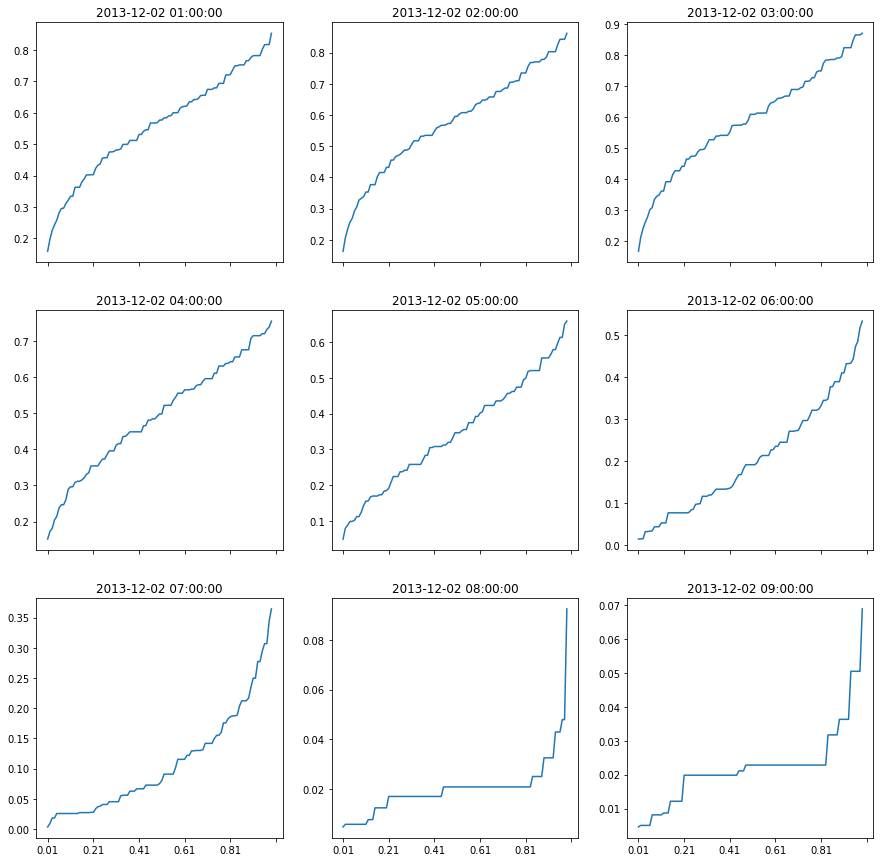

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [19]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [20]:
test_ts = np.squeeze(train_data1[-gefcom14_metadata['prediction_length']:].values)
loss = np.mean(pinnball_loss(test_ts, prediction))

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 10 with NNQF: 0.03185
